In [47]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

### 1. Read the train dataset 

In [2]:
train = pd.read_csv('./train_oSwQCTC/train.csv')

In [3]:
train.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200


In [4]:
test = pd.read_csv('test_HujdGe7/test.csv')
test.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN


### 2.  Submit the Base Model 

In [5]:
df = pd.DataFrame({'Purchase': 300, 'User_ID': test.User_ID, 'Product_ID': test.Product_ID})

### 3. Combine Train and Test Dataset 

In [6]:
combined = pd.concat([train,test], sort = False, ignore_index = False)

### 4. EDA 

C:\Users\Arpit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


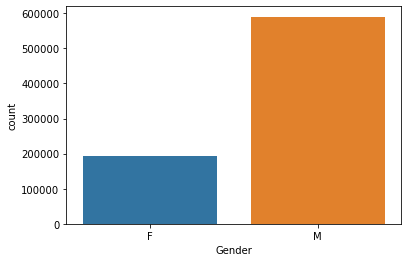

In [7]:
sns.countplot(combined['Gender'])
plt.show()

* During the black friday sale, generally male population is very high compared to females. 

C:\Users\Arpit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


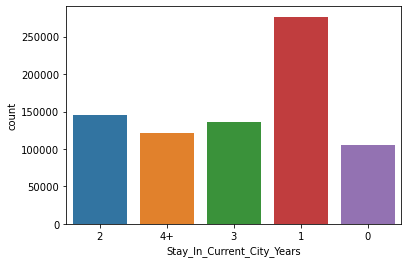

In [8]:
sns.countplot(combined['Stay_In_Current_City_Years'])
plt.show()

* Most of the people who have resided in the current city only for 1 year can be the target customers, since they are in majority.

In [9]:
combined = combined.drop(['User_ID','Product_ID'], axis = 1)
# drop the columns, that cannot contribute to make the model better

### 4. Encoding the categorical columns 

In [10]:
encoding_cat_vars = {'0-17': 1, '18-25': 2, '26-35': 3, '36-45': 4, '46-50': 5, '51-55': 6, '55+': 6 , 'F': 1, 'M': 0, '4+': 4,'A': 1, 'C': 3, 'B': 2}

In [11]:
combined = combined.applymap(lambda x:encoding_cat_vars.get(x) if x in encoding_cat_vars else x)

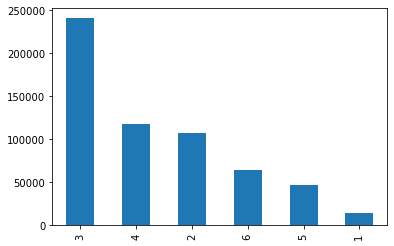

In [78]:
combined[combined['Gender'] == 0]['Age'].value_counts().plot(kind = 'bar')
plt.show()

* Males in the category 3 , i.e aged between 26-35 years, purchase most from the Black Friday Sales.

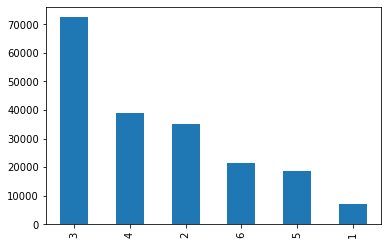

In [82]:
combined[combined['Gender'] == 1]['Age'].value_counts().plot(kind = 'bar')
plt.show()

### 5. Check the data types of the features 

In [12]:
combined.dtypes

Gender                          int64
Age                             int64
Occupation                      int64
City_Category                   int64
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                      float64
dtype: object

In [13]:
combined['Stay_In_Current_City_Years'] = combined['Stay_In_Current_City_Years'].astype('int64')
# change the data type of this column from object to numerical 

### 6. Impute the null values 

In [14]:
combined['Product_Category_2'] = combined['Product_Category_2'].fillna(combined['Product_Category_2'].mode().values[0])

In [15]:
combined['Product_Category_3'] = combined['Product_Category_3'].fillna(combined['Product_Category_3'].mode().values[0])

In [16]:
combined['Product_Category_2']= combined['Product_Category_2'].astype('int64')
# change the data type from object to numerical 

In [17]:
combined['Product_Category_3']= combined['Product_Category_3'].astype('int64')
# change the data type from object to numerical 

C:\Users\Arpit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


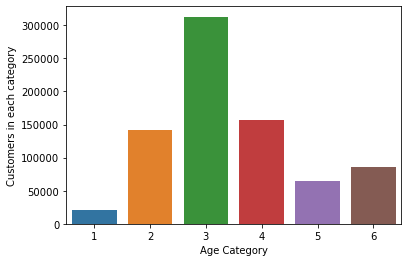

In [81]:
sns.countplot(combined['Age'])
plt.xlabel('Age Category')
plt.ylabel('Customers in each category')
plt.show()

* Most of the customers are aged between 26-35 years , followed by age group, 36-45 years of age. 

### Correlation of independent Features with The Target variable 

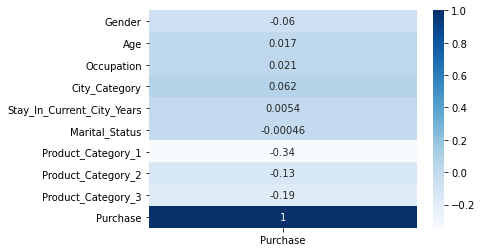

In [19]:
sns.heatmap(combined.corr()[['Purchase']], annot = True, cmap='Blues')
plt.show()

* Marital Status is weakly correlated, with the target variable, but dropping it increases the RMSE score.

In [26]:
new_train = combined.iloc[: train.shape[0], : ].drop('Purchase', axis = 1)

In [29]:
new_test = combined.iloc[train.shape[0] : , :  ].drop('Purchase', axis = 1)

### Linear Regression Model 

In [30]:
lr = LinearRegression()

In [31]:
y_train = train['Purchase']

In [32]:
model_bs = lr.fit(new_train, y_train)

In [33]:
y_pred_lr = model_bs.predict(new_test)

* RMSE Score of 4695.24

### XGBoost Model

In [34]:
xg = XGBRegressor()

In [35]:
model_xg = xg.fit(new_train, y_train)

In [36]:
y_pred_gb = model_xg.predict(new_test)

In [37]:
#df_xg = pd.DataFrame({'Purchase': y_pred_gb, 'User_ID': test.User_ID, 'Product_ID': test.Product_ID})

In [38]:
#df_xg.to_csv('xgmod.csv', index = False)

* XGBoost Model returns RMSE score of 2887.08

In [39]:
pd.DataFrame({'Feature Importance':model_xg.feature_importances_}, index = new_test.columns).sort_values(by = 'Feature Importance', ascending = False)

,Feature Importance
Product_Category_1,0.926256
Product_Category_3,0.019480
Product_Category_2,0.017324
City_Category,0.011118
Age,0.005745
Marital_Status,0.005224
Occupation,0.005022
Gender,0.004982
Stay_In_Current_City_Years,0.004848


* According to the Random Forest, Product_Category_1 is the most important feature 

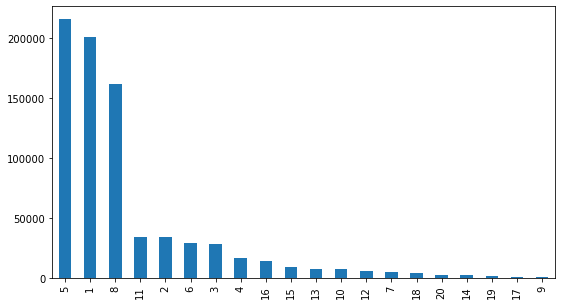

In [56]:
plt.figure(figsize = (9,5))
combined['Product_Category_1'].value_counts().plot(kind = 'bar')
plt.show()

* In Product_Category_1, product **5** is the most popular one.

### Average Sales generated by different Product Categories 

In [66]:
train.groupby(['Product_Category_1'])['Purchase'].mean().sum()

181438.47052167312

In [63]:
train.groupby(['Product_Category_2'])['Purchase'].mean().sum()

167816.40749944843

In [64]:
train.groupby(['Product_Category_3'])['Purchase'].mean().sum()

177138.45869198925

* Maximum Average Sales, is generated from Product Category_1, followed by Product_Category_3

### Random Forest Regressor 

In [40]:
rf = RandomForestRegressor()
model_rf = rf.fit(new_train, y_train)
y_pred_rf = model_rf.predict(new_test)
df_rf = pd.DataFrame({'Purchase': y_pred_rf, 'User_ID': test.User_ID, 'Product_ID': test.Product_ID})

* Random Forest Regressor returns the RMSE of 3029.64

## Inference : 

* Target customers for Black Friday Sales can be Males.



* The age-group that should be targeted the most is between 26-35 years.


* The poople who are new to the city, are mostly attracted to the sales. 


* The best model, which is giving the lowest RMSE score of 2887.04 is XGBoost Model.


* The model can be improved by applying Feature Engineering, by adding more features.


* According to the XGBoost Model, the most important feature, is Product_Category_1. 


* In product_category_1, product_5 is the most popular product, that is purchased maximum number of times.


* Out of all the product categories, Product_Category_1, generates the maximum average sales, followed by Product_Category_3.


* Males and Females in the age-category 3 , i.e aged between 26-35 years, purchase most from the Black Friday Sales.